In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

import zipfile
import warnings
warnings.filterwarnings('ignore')

import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchcontrib.optim import SWA
from torch.optim.lr_scheduler import _LRScheduler
from torchcontrib.optim import SWA
   
from sklearn.metrics import recall_score
from sklearn.utils import shuffle
from sklearn.model_selection import RepeatedStratifiedKFold
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import f1_score

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import math


import joblib
from tqdm.auto import tqdm
print('cuda on : ', torch.cuda.is_available())

cuda on :  True


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
name_label_dict = {
0:  'Nucleoplasm',
1:  'Nuclear membrane',
2:  'Nucleoli',   
3:  'Nucleoli fibrillar center',
4:  'Nuclear speckles',
5:  'Nuclear bodies',
6:  'Endoplasmic reticulum',   
7:  'Golgi apparatus',
8:  'Peroxisomes',
9:  'Endosomes',
10:  'Lysosomes',
11:  'Intermediate filaments',
12:  'Actin filaments',
13:  'Focal adhesion sites',   
14:  'Microtubules',
15:  'Microtubule ends',  
16:  'Cytokinetic bridge',   
17:  'Mitotic spindle',
18:  'Microtubule organizing center',  
19:  'Centrosome',
20:  'Lipid droplets',
21:  'Plasma membrane',   
22:  'Cell junctions', 
23:  'Mitochondria',
24:  'Aggresome',
25:  'Cytosol',
26:  'Cytoplasmic bodies',   
27:  'Rods & rings' }

In [87]:
# config

index = 0
HEIGHT = 224
WIDTH = 224

data_dir = "../Inputs/human-protein-atlas-image-classification/"


In [88]:
df_train = pd.read_csv(f'{data_dir}/train.csv')

In [89]:
%%time
df_train.head()

CPU times: total: 0 ns
Wall time: 1 ms


,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [90]:
pseudo = pd.read_csv(f'{data_dir}/ef-Kfold-3.csv')
pseudo = pseudo.drop( pseudo[pseudo.Predicted.isnull()].index ).reset_index(drop= True)
pseudo.columns = ['Id', 'Target']
df_train = pseudo
df_train.head()

# EDA

In [96]:
reverse_train_labels = dict((v,k) for k,v in name_label_dict.items())

In [97]:
reverse_train_labels

{'Nucleoplasm': 0,
 'Nuclear membrane': 1,
 'Nucleoli': 2,
 'Nucleoli fibrillar center': 3,
 'Nuclear speckles': 4,
 'Nuclear bodies': 5,
 'Endoplasmic reticulum': 6,
 'Golgi apparatus': 7,
 'Peroxisomes': 8,
 'Endosomes': 9,
 'Lysosomes': 10,
 'Intermediate filaments': 11,
 'Actin filaments': 12,
 'Focal adhesion sites': 13,
 'Microtubules': 14,
 'Microtubule ends': 15,
 'Cytokinetic bridge': 16,
 'Mitotic spindle': 17,
 'Microtubule organizing center': 18,
 'Centrosome': 19,
 'Lipid droplets': 20,
 'Plasma membrane': 21,
 'Cell junctions': 22,
 'Mitochondria': 23,
 'Aggresome': 24,
 'Cytosol': 25,
 'Cytoplasmic bodies': 26,
 'Rods & rings': 27}

In [98]:
for key in name_label_dict.keys():
    df_train[name_label_dict[key]] = 0

In [99]:
def fill_targets(row):
    row.Target = np.array(row.Target.split(" ")).astype(np.int)  # label -> list(int)로 변경 index matching
    for num in (row.Target):
        name = name_label_dict[int(num)]
        row.loc[name] = 1
    return row

In [100]:
df_train = df_train.apply(fill_targets, axis=1)   #label_dict와 Target match
df_train.head()

,Id,Target,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,...,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,[2],0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,"[5, 25]",0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,"[0, 25]",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,"[0, 25]",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,"[7, 23, 25]",0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,1,0,0


<AxesSubplot:>

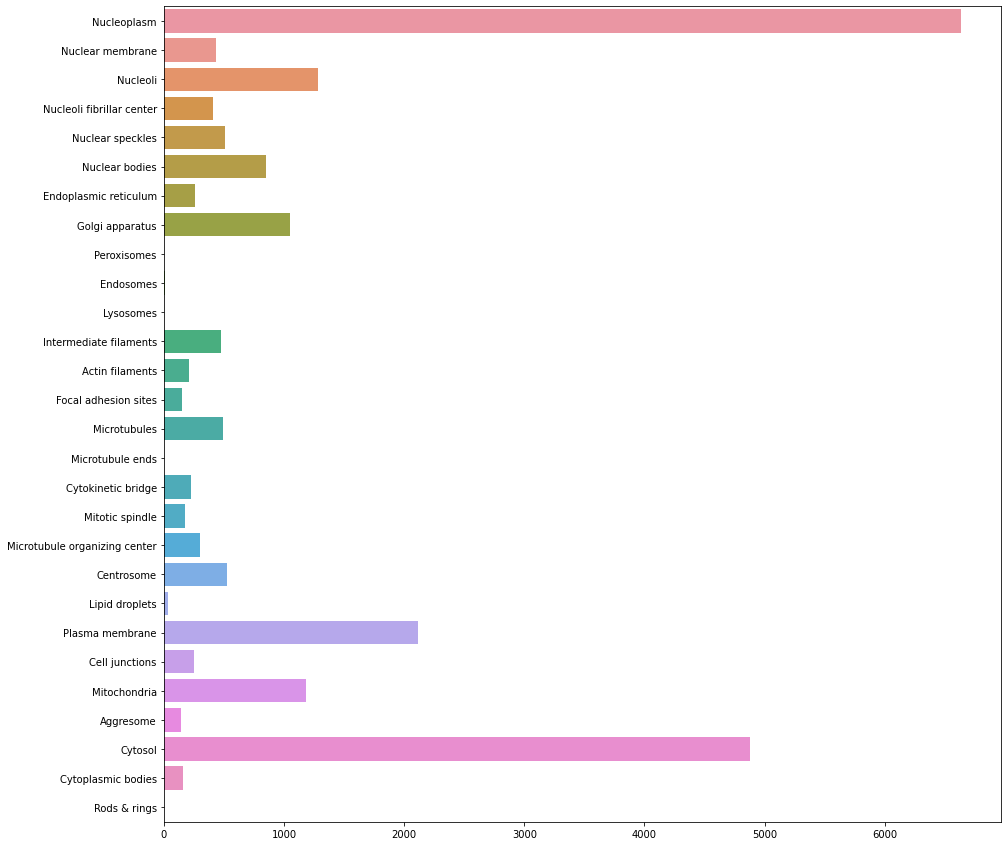

In [101]:
# Data 시각화  -> dataset bias가 높음

target_counts = df_train.drop(["Id", "Target"],axis=1).sum(axis=0)
plt.figure(figsize=(15,15))
sns.barplot(y=target_counts.index.values, x=target_counts.values, order=target_counts.index)

Text(0, 0.5, '% of train data')

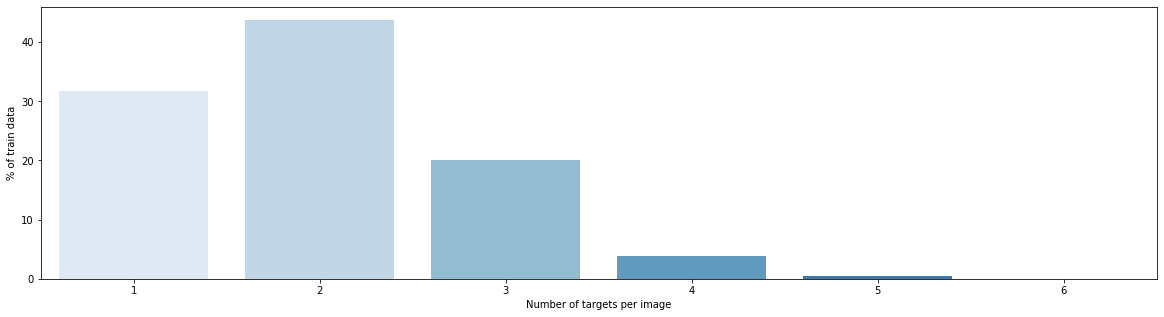

In [102]:
# 멀티 레이블을 가지는 사진의 비율 시각화, 1장의 image가 가지는 최대 레이블은 5개,   1~3개의 label을 가지는 비율이 90%에 가까움

df_train["number_of_targets"] = df_train.drop(["Id", "Target"],axis=1).sum(axis=1)
count_perc = np.round(100 * df_train["number_of_targets"].value_counts() / df_train.shape[0], 2)
plt.figure(figsize=(20,5))
sns.barplot(x=count_perc.index.values, y=count_perc.values, palette="Blues")
plt.xlabel("Number of targets per image")
plt.ylabel("% of train data")

<AxesSubplot:>

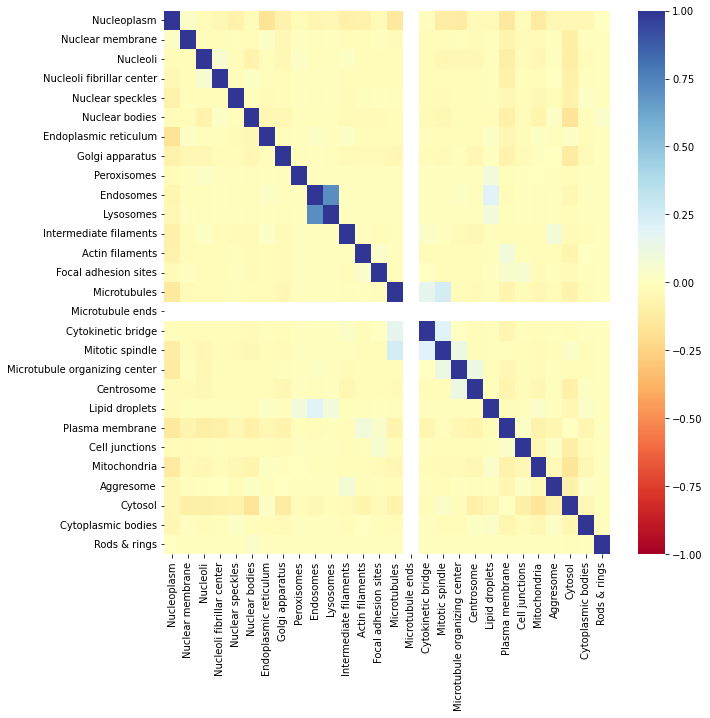

In [103]:
# 레이블 간의 상관관계 분석. 상관성이 있는 label들 확인

plt.figure(figsize=(10,10))
sns.heatmap(df_train[df_train.number_of_targets>1].drop(
    ["Id", "Target", "number_of_targets"],axis=1
).corr(), cmap="RdYlBu", vmin=-1, vmax=1)

# DataSet Split

In [104]:
train_files = os.listdir(f"{data_dir}/train")
test_files = os.listdir(f"{data_dir}/test")
percentage = np.round(len(test_files) / len(train_files) * 100)

print(f"train_data_set 대비 test_data_set이 {percentage} % 비율")

train_data_set 대비 test_data_set이 38.0 % 비율


In [105]:
# train  test 비율 38%  참고하여 3:1로 split
# label의 bias가 높아 MultilabelStratifiedKFold 를 사용하여 균등하게 split

mskf = MultilabelStratifiedKFold(n_splits= 4, shuffle=True, random_state= 42)

In [106]:
df_train["fold"] = -1

In [107]:
X = df_train['Id'].values

In [108]:
y = df_train.iloc[:, 2:-2].values

In [109]:
for i, (trn_idx, vld_idx) in enumerate(mskf.split(X, y)):
    df_train.loc[vld_idx, 'fold'] = i 

In [110]:
df_train["fold"].value_counts()

1    2924
2    2884
3    2876
0    2837
Name: fold, dtype: int64

In [111]:
trn_fold = [i for i in range(4) if i not in [2]]
vld_fold = [2]

In [112]:
trn_idx = df_train.loc[df_train['fold'].isin(trn_fold)].index
vld_idx = df_train.loc[df_train['fold'].isin(vld_fold)].index

# Define DataSet type B

In [113]:
class HPA_Dataset(Dataset):
  def __init__(self, csv, img_height, img_width, transform, is_test= False):
    self.csv = csv.reset_index()
    self.img_ids = csv['Id'].values
    self.img_height = img_height
    self.img_width = img_width
    self.transform = transform
    if is_test ==  False:
        is_test = 'train'
    else:
        is_test = 'test'
        
    self.is_test = is_test


  def __len__(self):
    return len(self.csv)


  def __getitem__(self, index):
    img_id = self.img_ids[index]
    img_red_ch = Image.open(f'{data_dir}/{self.is_test}/{img_id}'+'_red.png')
    img_green_ch = Image.open(f'{data_dir}/{self.is_test}/{img_id}'+'_green.png')
    img_blue_ch = Image.open(f'{data_dir}/{self.is_test}/{img_id}'+'_blue.png')
    img_yellow_ch = Image.open(f'{data_dir}/{self.is_test}/{img_id}'+'_yellow.png')
    
    img = np.stack([
    np.array(img_red_ch), 
    np.array(img_green_ch), 
    np.array(img_blue_ch),
    np.array(img_yellow_ch)], -1)
    
#     img = cv2.resize(img, (self.img_height,  self.img_width)).astype(np.uint8)/255
#     img = torch.Tensor(img).permute(2,0,1).numpy()
    
    if self.transform is not None:
      img = self.transform(image = img)['image']
    

    label = self.csv.iloc[:,3:-2].iloc[index]

    return img , np.array(label), img_id

In [119]:
import pickle

for i,j, idx in tqdm(HPA_Dataset( df_train, 512,512, None, is_test= True)):
    aa = []
    aa.append(i)
    aa.append(j)
    (pd.to_pickle(aa,f'{data_dir}/pickle/{idx}.pkl'))
#     print(i,j, idx)
#     break

  0%|          | 0/11521 [00:00<?, ?it/s]

,Id,Target,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,...,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings,number_of_targets,fold
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,[2],0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,"[5, 25]",0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,2,3
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,"[0, 25]",1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,2,1
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,"[0, 25]",1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,2,0
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,"[7, 23, 25]",0,0,0,0,0,0,0,1,...,0,0,0,1,0,1,0,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11516,ffdfb96a-bad4-11e8-b2b8-ac1f6b6435d0,[11],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2
11517,ffdfc590-bad4-11e8-b2b8-ac1f6b6435d0,"[0, 5, 25]",1,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,3,3
11518,ffecb8a4-bad4-11e8-b2b8-ac1f6b6435d0,"[7, 23]",0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,2,3
11519,fff03816-bad5-11e8-b2b9-ac1f6b6435d0,"[0, 1]",1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0


In [ ]:
i.mean()

In [ ]:
# data = pd.read_pickle(f'./{idx}.pkl')


data[1]

# Define augmentations

In [ ]:
# cutmix or cutout을 추가해서 실험할 예정

train_aug = A.Compose([
    A.Resize(224, 224),
    A.OneOf([
      A.HorizontalFlip(p=0.3),
      A.RandomRotate90(p=0.3),
      A.VerticalFlip(p=0.3)            
    ], p=0.4),
    A.OneOf([
      A.MotionBlur(p=0.3),
      A.OpticalDistortion(p=0.3),
      A.GaussNoise(p=0.3)                 
    ], p=0.4),
#     A.Normalize([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814]),
    A.pytorch.transforms.ToTensorV2()
])

vaild_aug = A.Compose([
#     A.Normalize([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814]),
    A.Resize(224,224),
    A.pytorch.transforms.ToTensorV2()
])

# Make dataloader

In [ ]:
# len(partitions)

# TFrecod 로 파일을 변환해뒀으면 더 효육적이고 빠른 학습이 가능했을듯

In [ ]:
# for data in ['train', 'valid']:
#     dataset = []
#     for idx in range(len(partitions)):
#         dataset.append(f'df_{data}_f{idx}')
#     globals()[f'{data}_csv'] = dataset
num  = 0 


def trn_dataset(num, is_test= False):
    trn_dataset = HPA_Dataset(csv =  df_train.iloc[trn_idx],
                                 img_height = HEIGHT,
                                 img_width = WIDTH,
                                 transform = train_aug,
                                 is_test = is_test,
                              )
    return trn_dataset

def vld_dataset(num, is_test= False):
    vld_dataset = HPA_Dataset(csv = df_train.iloc[vld_idx],
                                img_height = HEIGHT,
                                img_width = WIDTH,
                                transform = vaild_aug,
                                is_test = is_test,
                             )
    return vld_dataset


def trn_loader(num, is_test= False):
    trn_loader = DataLoader(trn_dataset(num, is_test),
                           shuffle = True,
                           num_workers = 2,
                           batch_size = 24,
                           )
    return trn_loader

def vld_loader(num, is_test= False):
    vld_loader = DataLoader(vld_dataset(num, is_test),
                           num_workers = 2,
                           batch_size = 24,
                           )
    return vld_loader

# Create model, opt, criterion

In [ ]:
# !pip install torch_lr_finder
import timm

# Model list

In [ ]:
timm.list_models(pretrained=True)

In [ ]:
# https://github.com/lucidrains/vit-pytorch

class ViT(nn.Module):
    def __init__(self, class_n=28):
        super().__init__()
        self.model = timm.create_model('tf_efficientnetv2_b3', pretrained=True, num_classes=28, in_chans= 4)
        
#         w = self.model.patch_embed.proj.weight
#         self.model.patch_embed.proj = nn.Conv2d(4, 768, kernel_size=(16, 16), stride=(16, 16))
#         self.model.patch_embed.proj.weight = torch.nn.Parameter(torch.cat((w,torch.zeros(768,1,16,16)),dim=1))       
        
#         self.model.head = nn.Sequential(nn.Dropout(0.5), nn.Linear(in_features=768, out_features=28, bias=True))

    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
model = ViT()

In [ ]:
model

In [ ]:
model.model.conv_stem.weight[:,0:,:,:]


In [ ]:
# 8개까지 freeze()
# requires_grad = False
# for idx, params in enumerate(model.parameters()):
#     if idx <= (155 - 8):
#         params.requires_grad = False


In [ ]:
# for i in filter(lambda p: p.requires_grad, model.parameters()):
#     print(i.requires_grad)

In [ ]:
model = model.cuda()

In [ ]:
# https://becominghuman.ai/investigating-focal-and-dice-loss-for-the-kaggle-2018-data-science-bowl-65fb9af4f36c
# https://arxiv.org/pdf/1708.02002.pdf
# 데이터 불균형에 적합한 loss funtion을 선택  1:10, 1000에 굉장히 유리하다는 평가가 있음.

class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()
    
loss_fn = FocalLoss()


In [ ]:
#BCEWithLogitsLoss : threshold기준으로 [1,0,0,1,0]식으로 표현 하기위해 sigmoid가 결합된 Binary Cross Entropy를 선택

# loss_fn = nn.BCEWithLogitsLoss()

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
#                                                       mode='max',
#                                                       verbose = True,
#                                                       patience=3,
#                                                       factor = 0.5,
#                                                       threshold = 1e-2,
#                                                        )

In [ ]:
# https://gaussian37.github.io/dl-pytorch-lr_scheduler/ 블로그 참조


class CosineAnnealingWarmUpRestarts(_LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)
    
    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
                
        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

In [ ]:
# 학습전 최적의 lr find

from torch_lr_finder import LRFinder
def finder():
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-8, weight_decay=1e-2)
    lr_finder = LRFinder(model, optimizer, loss_fn, device="cuda")
    lr_finder.range_test(trn_loader(0), end_lr=200, num_iter=200)
    lr_finder.plot() # to inspect the loss-learning rate graph
    lr_finder.reset() # to reset the model and optimizer to their initial state
    
if __name__ == '__main__':
    finder()

In [ ]:
# AdamW : 컴퓨터 비젼 task에서는 momentum을 포함한 SGD에 비해 일반화(generalization)가 많이 뒤쳐진다는 결과들이 있고
# 멀티 클래스, 멀티 레이블, 클래스 불균형으로 인한 일반화에 더 집중된 옵티마이저가 유리하다고 판단.

# 참고문헌 : https://hiddenbeginner.github.io/deeplearning/paperreview/2019/12/29/paper_review_AdamW.html
     
# lr finder 로 찾은 lr을 적용

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = 3.51E-04)
# optimizer = torch.optim.SGD(model.parameters(), lr = 1.75E-04, momentum=0.9)
# optimizer = SWA(optimizer, swa_start=10, swa_freq=5, swa_lr=1e-5)



In [ ]:
# model logit값 sigmoid로 0~1값 변환
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))


# 초기 값은 0.4  -> model이 학습한 후 예측값을 기준으로 True 데이터 비율이 높고 False 데이터 비율이 낮은 최적의 Thresholds값을
# labels 별로 각각 28개 구해서 진행
Thresholds = 0.4

In [ ]:
# warmup!
final_score = []
for ep in range(1):
    train_loss = []
    val_loss = []
    val_true = []
    val_pred = []

    print(f'======================== {ep} warmup train start ========================') 

    model.train()
    for inputs, targets in tqdm(trn_loader(ep)):

        inputs = inputs.cuda()  # gpu 환경에서 돌아가기 위해 cuda()
        targets = targets.cuda() #정답 데이터
        logits = model(inputs.float()) # 결과값 
        # 변화도(Gradient) 매개변수를 0
        optimizer.zero_grad()
        # 순전파 + 역전파 + 최적화
        loss = loss_fn(logits,  targets.float())
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
    model.eval()
    with torch.no_grad():
        for inputs, targets in tqdm(vld_loader(ep)):
            inputs = inputs.cuda()
            targets = targets.cuda()

            logits = model(inputs.float())

            loss = loss_fn(logits, targets.float())
            val_loss.append(loss.item())

            # 정답 비교 code
            pred = np.where(sigmoid_np(logits.cpu().detach().numpy()) > Thresholds, 1, 0)
            F1_score = f1_score(targets.cpu().numpy(), pred , average='macro')
            final_score.append(F1_score)

    Val_loss_ = np.mean(val_loss) 
    Train_loss_ = np.mean(train_loss)
    Final_score_ = np.mean(final_score)
    print(f'train_loss : {Train_loss_:.5f}; val_loss: {Val_loss_:.5f}; f1_score: {Final_score_:.5f}')

In [ ]:
import gc

torch.cuda.empty_cache()
gc.collect()

In [ ]:
# unfreeze() 파라미터 requires_grad all true
# for idx, params in enumerate(model.parameters()):
#     params.requires_grad = True

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = 1.0E-06)
scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0= 20, T_mult=1, eta_max=5.0E-03,  T_up=3, gamma=0.5)

In [ ]:
best_score = -1
final_score = []
title = 'TW_ViT_model_Adam_pure'
lrs = []
early_stop = np.inf
for ep in range(60):
    train_loss = []
    val_loss = []
    val_true = []
    val_pred = []

    print(f'======================== {ep} Epoch train start ========================') 


    model.train()
    for inputs, targets in tqdm(trn_loader(ep)):

        inputs = inputs.cuda()  # gpu 환경에서 돌아가기 위해 cuda()
        targets = targets.cuda() #정답 데이터
        
        # 변화도(Gradient) 매개변수를 0
        optimizer.zero_grad()
        logits = model(inputs.float()) # 결과값 

        # 순전파 + 역전파 + 최적화
        loss = loss_fn(logits,  targets.float())
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())
        
    model.eval()
    with torch.no_grad():
        for inputs, targets in tqdm(vld_loader(ep)):
            inputs = inputs.cuda()
            targets = targets.cuda()

            logits = model(inputs.float())

            loss = loss_fn(logits, targets.float())


            val_loss.append(loss.item())

            # 정답 비교 code
            pred = np.where(sigmoid_np(logits.cpu().detach().numpy()) > Thresholds, 1, 0)
            F1_score = f1_score(targets.cpu().numpy(), pred , average='macro')
            final_score.append(F1_score)

    Val_loss_ = np.mean(val_loss) 
    Train_loss_ = np.mean(train_loss)
    Final_score_ = np.mean(final_score)
    print(f'train_loss : {Train_loss_:.5f}; val_loss: {Val_loss_:.5f}; f1_score: {Final_score_:.5f}')
    scheduler.step()
    lrs.append(optimizer.param_groups[0]['lr'])
    print("lr: ", optimizer.param_groups[0]['lr'])
    
    if Final_score_ > best_score and early_stop > Val_loss_:
        best_score = Final_score_
        early_stop = Val_loss_
        early_count = 0
        state_dict = model.cpu().state_dict()
        model = model.cuda()
        torch.save(state_dict, f"../model/HPA/{title}_{ep}.pt")

        print('\n SAVE MODEL UPDATE \n\n')
    elif early_stop < Val_loss_ or Final_score_ < best_score:
        early_count += 1

    if early_count == 5:
        print('early stop!!!')
        break    

# optimizer.swap_swa_sgd()

In [ ]:
plt.plot(lrs)

# Model load

In [ ]:
# https://arxiv.org/abs/2106.10270  모델 선택 참고 논문 
# 레귤라이제이션 의 비효율 
# 데이터의 양이 많은 것이 학습된 모델이 더 효과적임

In [ ]:
# model.load_state_dict(torch.load('./TW_ViT_model.pt'))

# Inference

In [ ]:
def test_dataset(num, is_test= False):
    test_dataset = HPA_Dataset(csv = num,
                                img_height = HEIGHT,
                                img_width = WIDTH,
                                transform = vaild_aug,
                                is_test = is_test,
                             )
    return test_dataset


def test_loader(num, is_test= False):
    test_loader = DataLoader(test_dataset(num, is_test),
                           batch_size = 32,
                           )
    return test_loader

In [ ]:
submit = pd.read_csv(f'{data_dir}/sample_submission.csv')

In [ ]:
pred = []
for inputs, labels in tqdm(test_loader(submit, is_test = True)):
    model.eval()
    with torch.no_grad():
        inputs = inputs.cuda()    
        logits = model(inputs.float())
        
        pred.append(sigmoid_np(logits.cpu().detach().numpy()))

In [ ]:
def save_pred(pred, th=0.5, fname= title):
    pred_list = []
    for line in tqdm(pred):
        for idx in line:
            s = ' '.join(list([str(i) for i in np.nonzero(idx >th)[0]]))
            pred_list.append(s)
    submit['Predicted'] = pred_list
    submit.to_csv(f'../outputs/{fname}',  index=False)
    
save_pred(pred,Thresholds)

In [ ]:
# end